## Description
This is standard code using EfficientNetB7 model (S1). This model along with 3 other models are [used in an ensemble](https://www.kaggle.com/haveri/flowerflowerwhoareyou-onlysubmissions-ensembling).<p>
The other 3 models uses:<br>
S2 - EfficientNetB7<br>
S3 - DenseNet201<br>
S4 - DenseNet201<br>
<br>
For training apart from the default competition training set, this model uses additional data from the [5 image source provided by Kirill Blinov](https://www.kaggle.com/kirillblinov/tf-flower-photo-tfrec). For validation of the model, the default competition validation set is used.<p>
The image size used is [224, 224]<br>
LR_MAX used for this kernel is 0.00005 * strategy.num_replicas_in_sync<br>
LR_EXP_DECAY used for this kernel is 0.80<br>
Early stopping is used while monitoring for val_loss.<br>
Number of Epochs is set to a maximum of 50.<p>
Results obtained from each of these models are saved and reused during ensembling. The values stored include validation probabilities and test probabilities derived from the model predictions.<br>

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, gc
import numpy as np # linear algebra
import pickle
from datetime import datetime, timedelta
import tensorflow as tf
import efficientnet.tfkeras as efficientnet
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print('TensorFlow version', tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.1.0


## Initial Setup

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Replicas:', strategy.num_replicas_in_sync)

GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
MORE_IMAGES_GCS_DS_PATH = KaggleDatasets().get_gcs_path('tf-flower-photo-tfrec')
print(GCS_DS_PATH, '\n', MORE_IMAGES_GCS_DS_PATH)
#!ls -l /kaggle/input/tf-flower-photo-tfrec/*/tfrecords-jpeg-224x224/*.tfrec
#!ls -l /kaggle/input/tf-flower-photo-tfrec/imagenet/tfrecords-jpeg-224x224/*.tfrec
#!ls -l /kaggle/input/tf-flower-photo-tfrec/inaturalist/tfrecords-jpeg-224x224/*.tfrec
#!ls -l /kaggle/input/tf-flower-photo-tfrec/openimage/tfrecords-jpeg-224x224/*.tfrec
#!ls -l /kaggle/input/tf-flower-photo-tfrec/oxford_102/tfrecords-jpeg-224x224/*.tfrec
#!ls -l /kaggle/input/tf-flower-photo-tfrec/tf_flowers/tfrecords-jpeg-224x224/*.tfrec

Running on TPU grpc://10.0.0.2:8470
Replicas: 8
gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543 
 gs://kds-9861789129e0fb621cecc0785dbc22957b5cc1e0c58cee3f180c932a


In [4]:
start_time = datetime.now()
print('Time now is', start_time)
end_training_by_tdelta = timedelta(seconds=8400)
this_run_file_prefix = start_time.strftime('%Y%m%d_%H%M_')
print(this_run_file_prefix)

IMAGE_SIZE = [331, 331]

EPOCHS = 12
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = {
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

MOREIMAGES_PATH_SELECT = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
MOREIMAGES_PATH = MOREIMAGES_PATH_SELECT[IMAGE_SIZE[0]]

IMAGENET_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/imagenet' + MOREIMAGES_PATH + '/*.tfrec')
INATURELIST_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/inaturalist' + MOREIMAGES_PATH + '/*.tfrec')
OPENIMAGE_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/openimage' + MOREIMAGES_PATH + '/*.tfrec')
OXFORD_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/oxford_102' + MOREIMAGES_PATH + '/*.tfrec')
TENSORFLOW_FILES = tf.io.gfile.glob(MORE_IMAGES_GCS_DS_PATH + '/tf_flowers' + MOREIMAGES_PATH + '/*.tfrec')
ADDITIONAL_TRAINING_FILENAMES = IMAGENET_FILES + INATURELIST_FILES + OPENIMAGE_FILES + OXFORD_FILES + TENSORFLOW_FILES
#print(VALIDATION_FILENAMES)
print('----')
TRAINING_FILENAMES = TRAINING_FILENAMES + ADDITIONAL_TRAINING_FILENAMES
print(TRAINING_FILENAMES)

# This is so awkward. Everyone is doing this for an extra few points.
# TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES
# VALIDATION_FILENAMES = TRAINING_FILENAMES

CLASSES = ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', # 00 - 09
           'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', # 10 - 19
           'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', # 20 - 29
           'carnation', 'garden phlox', 'love in the mist', 'cosmos', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', # 30 - 39
           'barberton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'daisy', 'common dandelion', # 40 - 49
           'petunia', 'wild pansy', 'primula', 'sunflower', 'lilac hibiscus', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia', # 50 - 59
           'cautleya spicata', 'japanese anemone', 'black-eyed susan', 'silverbush', 'californian poppy', 'osteospermum', 'spring crocus', 'iris', 'windflower', 'tree poppy', # 60 - 69
           'gazania', 'azalea', 'water lily', 'rose', 'thorn apple', 'morning glory', 'passion flower', 'lotus', 'toad lily', 'anthurium', # 70 - 79
           'frangipani', 'clematis', 'hibiscus', 'columbine', 'desert-rose', 'tree mallow', 'magnolia', 'cyclamen ', 'watercress', 'canna lily', # 80 - 89
           'hippeastrum ', 'bee balm', 'pink quill', 'foxglove', 'bougainvillea', 'camellia', 'mallow', 'mexican petunia', 'bromelia', 'blanket flower', # 90 - 99
           'trumpet creeper', 'blackberry lily', 'common tulip', 'wild rose'] # 100 - 102

Time now is 2020-05-10 11:22:05.270220
20200510_1122_
----
['gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/00-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/01-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/02-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/03-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/04-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/05-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/06-331x331-798.tfrec', 'gs://kds-c6e85e0a1f68b01fced7716d92657769cd5fee0666846c3d02fbb543/tfrecords-jpeg-331x331/train/07-331x331-

Out of 4 models used for ensembling, two of the models use LR_EXP_DECAY of 0.8 and two of the models use 0.75.

In [5]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = LR_START
LR_RAMPUP_EPOCHS = 6
LR_SUSTAIN_EPOCHS = 4 # 3
LR_EXP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (epoch * (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS)
    elif epoch < (LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS):
        lr = LR_MAX
    else:
        lr = LR_MIN + (LR_MAX - LR_MIN) * LR_EXP_DECAY ** (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
#    print('For epoch', epoch, 'setting lr to', lr)
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(20)]
y = [lrfn(x) for x in rng]
print(y)

[1e-05, 7.5e-05, 0.00014, 0.000205, 0.00027, 0.000335, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.00030250000000000003, 0.000229375, 0.00017453125, 0.0001333984375, 0.00010254882812499999, 7.941162109375e-05, 6.20587158203125e-05, 4.9044036865234376e-05, 3.928302764892578e-05]


## Helper Functions

In [6]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image
#

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label
#

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum
#

def load_dataset(filenames, labeled = True, ordered = False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO)
    return dataset
#

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label
#

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_validation_dataset(ordered = False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled = True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def get_test_dataset(ordered = False):
    dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset
#

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)
#

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


In [8]:
print('Training data shapes')
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print('Training data label examples:', label.numpy())
#

print('Validation data shapes')
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print('Validation data label examples:', label.numpy())
#

print('Test data shapes')
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print('Test data IDs:', idnum.numpy().astype('U'))

Training data shapes
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Training data label examples: [  8  47  30 ... 103   4  68]
Validation data shapes
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Validation data label examples: [10 49 79 ... 12 54 42]
Test data shapes
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
(128, 331, 331, 3) (128,)
Test data IDs: ['f2586d647' '053198ea7' 'a622a8c05' ... 'a41d29902' 'bf4c39972' '0d48d68af']


In [9]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)
#
#display_batch_of_images(next(train_batch))

In [10]:
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)
#
#display_batch_of_images(next(test_batch))

## Model Setup and Training
A lot of code below are not used in this particular notebook. But code previously used in other notebooks were not deleted intentionally. It should give an indication on the different kinds of experiments one could run for this competition.

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights = True)

In [12]:
class CosLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(CosLayer, self).__init__()
        self.units = units
#         self.w = self.add_weight('kernel', shape=(2560, self.units),
#                                  initializer='random_normal',
#                                  trainable=True)
    
    def build(self, input_shape):
        self.w = self.add_weight('kernel', shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        w = tf.math.l2_normalize(self.w, axis=0, name='weight_normalization')
        inputs = tf.math.l2_normalize(inputs, axis=-1, name='feature_normalization')
#         a_w = tf.sqrt(tf.reduce_sum(self.w ** 2, axis=, keepdims))
        outputs = tf.matmul(inputs, w)
        return tf.clip_by_value(outputs, -1,1)

    
def am_loss(y_true, y_pred):
    
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(tf.squeeze(y_true, axis=-1), len(CLASSES))
    y_pred = tf.exp(10 * (y_pred - 0.3 * y_true))
    
    numerator = tf.reduce_sum(y_pred * y_true, axis=-1)
    denominator = tf.reduce_sum(y_pred, axis=-1)
    am_loss = -tf.math.log(numerator/(denominator+1e-8))
    
    return tf.reduce_mean(am_loss)

In [13]:
def create_VGG16_model():
    pretrained_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [14]:
def create_VGG16_model_am_loss():
    pretrained_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True # False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model

In [15]:
def create_Xception_model():
    pretrained_model = tf.keras.applications.Xception(include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [16]:
def create_Xception_model_am_loss():
    pretrained_model = tf.keras.applications.Xception(include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model


In [17]:
def create_DenseNet_model():
    pretrained_model = tf.keras.applications.DenseNet201(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [18]:
def create_DenseNet_model_am_loss():
    pretrained_model = tf.keras.applications.DenseNet201(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model

In [19]:
def create_EfficientNet_model():
    pretrained_model = efficientnet.EfficientNetB7(weights = 'noisy-student', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [20]:
def create_EfficientNet_model_am_loss():
    pretrained_model = efficientnet.EfficientNetB7(weights = 'noisy-student', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model

In [21]:
def create_InceptionV3_model():
    pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [22]:
def create_InceptionV3_model_am_loss():
    pretrained_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model

In [23]:
def create_ResNet152_model():
    pretrained_model = tf.keras.applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [24]:
def create_MobileNetV2_model():
    pretrained_model = tf.keras.applications.MobileNetV2(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [25]:
def create_InceptionResNetV2_model():
    pretrained_model = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation = 'softmax')
    ])

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])
    return model

In [26]:
def create_InceptionResNetV2_model_am_loss():
    pretrained_model = tf.keras.applications.InceptionResNetV2(weights = 'imagenet', include_top = False, input_shape = [*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        CosLayer(len(CLASSES))
    ])

    model.compile(optimizer = 'adam', loss = am_loss, metrics = ['sparse_categorical_accuracy'])
    return model

In [27]:
no_of_models = 1
models = [0] * no_of_models
start_model = 0
end_model = 1
model_indx_0 = start_model
#model_indx_1 = start_model + 1
#model_indx_2 = start_model + 2

val_probabilities = [0] * no_of_models
test_probabilities = [0] * no_of_models
all_probabilities = [0] * no_of_models

Out of the four models used in ensembling, two of the models use EfficientNetB7 and two others use DenseNet201.

In [28]:
#with strategy.scope():
#    models[0] = create_DenseNet_model()
#    models[1] = create_EfficientNet_model()
#print(models[0].summary())
#print(models[1].summary())
#
with strategy.scope():
    for j in range(no_of_models):
#        models[j] = create_VGG16_model()
#        models[j] = create_Xception_model()
#        models[j] = create_DenseNet_model()
#        models[j] = create_EfficientNet_model()
         models[j] = create_InceptionV3_model()
#        models[j] = create_ResNet152_model()
#        models[j] = create_MobileNetV2_model()
#        models[j] = create_InceptionResNetV2_model()
#        models[j] = create_Xception_model_am_loss()
#        models[j] = create_DenseNet_model_am_loss()
#        models[j] = create_EfficientNet_model_am_loss()
#        models[j] = create_InceptionV3_model_am_loss()
#        models[j] = create_ResNet152_model()
#        models[j] = create_MobileNetV2_model()
#        models[j] = create_InceptionResNetV2_model_am_loss()

models[0].summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 9, 9, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               213096    
Total params: 22,015,880
Trainable params: 21,981,448
Non-trainable params: 34,432
_________________________________________________________________


In [29]:
def write_history(j):
    history_dict = [0] * no_of_models
    for i in range(j + 1):
        if (historys[i] != 0):
            history_dict[i] = historys[i].history
#
    filename = './' + this_run_file_prefix + 'model_history_' + str(j) + '.pkl'
    pklfile = open(filename, 'ab')
    pickle.dump(history_dict, pklfile)
    pklfile.close()

In [30]:
EPOCHS = 50 # 35 # 2 # 20
historys = [0] * no_of_models
#lr_exp_decay_values = [0.5,0.6,0.5,0.7] # [0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9,0.6,0.7,0.8,0.9,0.5,0.5,0.5,0.5]
#lr_max_values = [0.00005,0.00003,0.00004,0.00003] # [0.00003,0.00003,0.00003,0.00003,0.00004,0.00004,0.00004,0.00004,0.00005,0.00005,0.00005,0.00005,0.00006,0.00006,0.00006,0.00006,0.00003,0.00004,0.00005,0.00006]
finished_models = 0

for j in range(start_model, end_model):
    start_training = datetime.now()
    print(start_training)
    time_from_start_program_tdelta = start_training - start_time
    if time_from_start_program_tdelta > end_training_by_tdelta:
        print(j, 'time limit for doing training over, get out')
        break
#    with strategy.scope():
#        models[j] = create_DenseNet_model()
#    if j == 0:
#        models[0].summary()
#        print('----------------------------------------------------')
#    LR_EXP_DECAY = lr_exp_decay_values[j]
#    LR_MAX = lr_max_values[j] * strategy.num_replicas_in_sync
    print('LR_EXP_DECAY:', LR_EXP_DECAY, '. LR_MAX:', LR_MAX)
    historys[j] = models[j].fit(get_training_dataset(), steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, validation_data = get_validation_dataset(), callbacks = [lr_callback, early_stop])
    write_history(j)
    filename = this_run_file_prefix + 'models_' + str(j) + '.h5'
    models[j].save(filename)
#    model_to_delete = models[j]
#    models[j] = 0
#    del model_to_delete
    gc.collect()
    finished_models = j + 1

print(datetime.now())
#

2020-05-10 11:22:50.472452
LR_EXP_DECAY: 0.75 . LR_MAX: 0.0004
Train for 531 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
531/531 [==============================] - 179s 338ms/step - loss: 2.8990 - sparse_categorical_accuracy: 0.3903 - val_loss: 2.4396 - val_sparse_categorical_accuracy: 0.4407

Epoch 00002: LearningRateScheduler reducing learning rate to 7.5e-05.
Epoch 2/50
531/531 [==============================] - 92s 174ms/step - loss: 0.9997 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.7476

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00014.
Epoch 3/50
531/531 [==============================] - 93s 175ms/step - loss: 0.5872 - sparse_categorical_accuracy: 0.8480 - val_loss: 0.9258 - val_sparse_categorical_accuracy: 0.7645

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000205.
Epoch 4/50
531/531 [==============================] - 91s 171ms/step - loss: 0.4892 

In [31]:
cmdataset = get_validation_dataset(ordered = True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy()

In [32]:
test_ds = get_test_dataset(ordered = True)

#print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
#

In [33]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

images, labels = next(batch)

In [34]:
print(datetime.now())
#
for j in range(start_model, end_model):
    val_probabilities[j] = models[j].predict(images_ds)
    test_probabilities[j] = models[j].predict(test_images_ds)
    all_probabilities[j] = models[j].predict(images)

print(datetime.now())
#

2020-05-10 12:34:51.288156
2020-05-10 12:35:47.260193


model number: 0 , Train Accuracy: 0.9988524 , Validation Accuracy: 0.9512392
model number: 0 , Train Loss: 0.005503904495531651 , Validation Loss: 0.3080344868117365


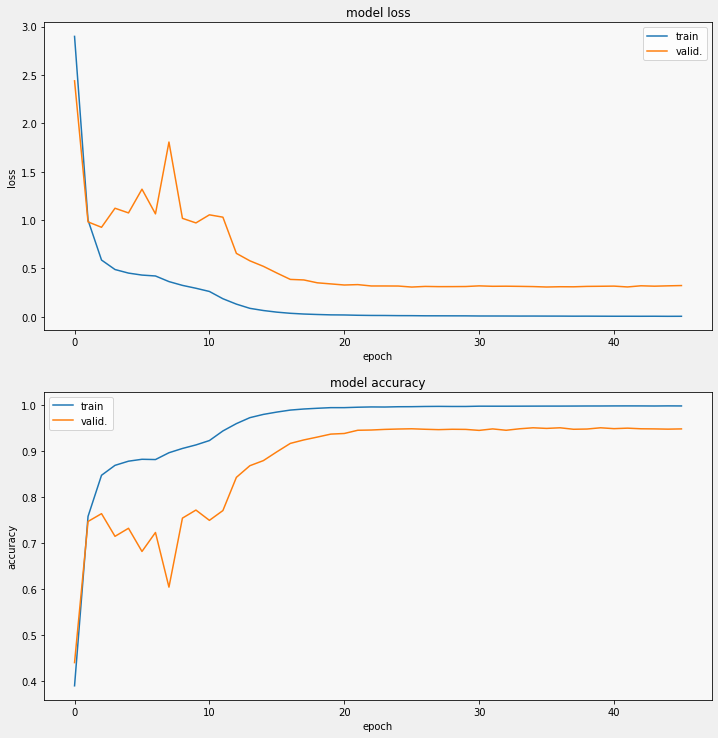

In [35]:
for j in range(start_model, finished_models):
    display_training_curves(historys[j].history['loss'], historys[j].history['val_loss'], 'loss', 211)
    display_training_curves(historys[j].history['sparse_categorical_accuracy'], historys[j].history['val_sparse_categorical_accuracy'], 'accuracy', 212)
#
for j in range(start_model, finished_models):
    print('model number:', j, ', Train Accuracy:', max(historys[j].history['sparse_categorical_accuracy']), ', Validation Accuracy:', max(historys[j].history['val_sparse_categorical_accuracy']))
for j in range(start_model, finished_models):
    print('model number:', j, ', Train Loss:', min(historys[j].history['loss']), ', Validation Loss:', min(historys[j].history['val_loss']))
#

In [36]:
cm_probabilities = np.zeros((val_probabilities[0].shape)) # = val_probabilities[0] + val_probabilities[1] + val_probabilities[2]
for j in range(no_of_models):
    cm_probabilities = cm_probabilities + val_probabilities[j]

cm_predictions = np.argmax(cm_probabilities, axis = -1)
print('Correct labels: ', cm_correct_labels.shape, cm_correct_labels)
print('Predicted labels: ', cm_predictions.shape, cm_predictions)

Correct labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


In [37]:
def getFitPrecisionRecall(correct_labels, predictions):
    score = f1_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    precision = precision_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    recall = recall_score(correct_labels, predictions, labels = range(len(CLASSES)), average = 'macro')
    return score, precision, recall
#

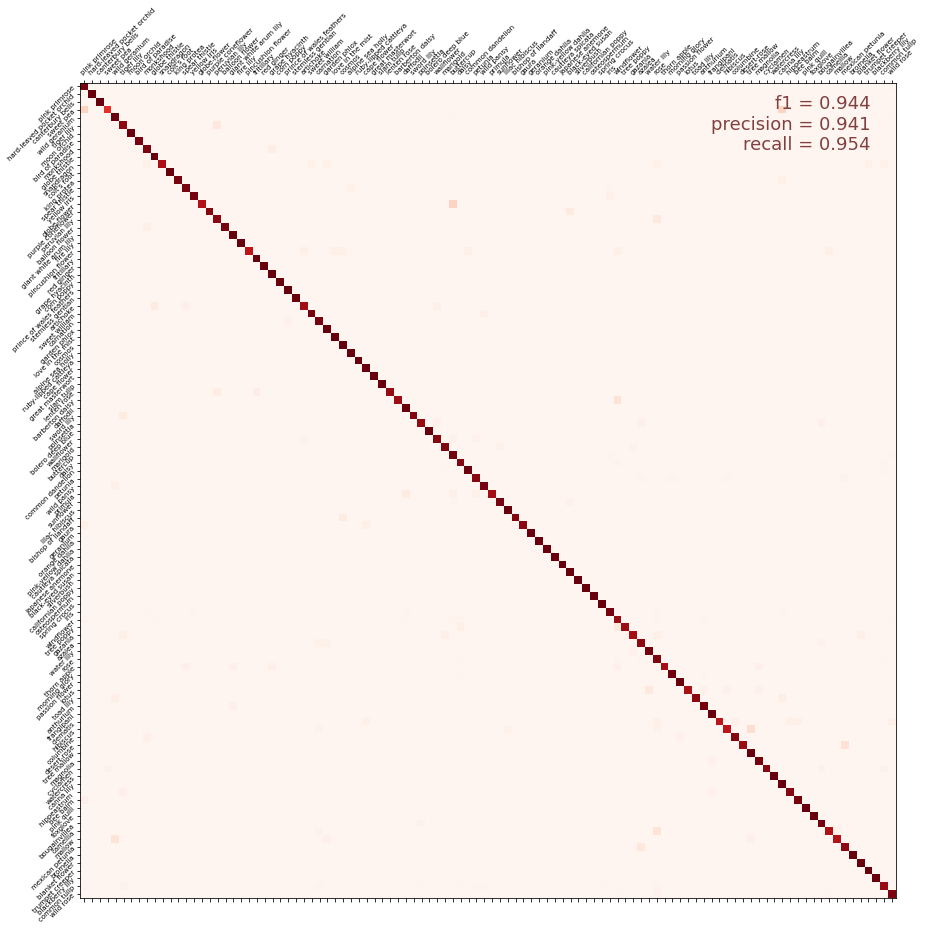

f1 score: 0.944, precision: 0.941, recall: 0.954


In [38]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels = range(len(CLASSES)))
score, precision, recall = getFitPrecisionRecall(cm_correct_labels, cm_predictions)
cmat = (cmat.T / cmat.sum(axis = -1)).T
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

In [39]:
def create_submission_file(filename, probabilities):
    predictions = np.argmax(probabilities, axis = -1)
    print('Generating submission file...', filename)
    test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

    np.savetxt(filename, np.rec.fromarrays([test_ids, predictions]), fmt = ['%s', '%d'], delimiter = ',', header = 'id,label', comments = '')
#

In [40]:
probabilities = np.zeros((test_probabilities[0].shape)) # = test_probabilities[0] + test_probabilities[1] + test_probabilities[2]
for j in range(no_of_models):
    probabilities = probabilities + test_probabilities[j]

filename = this_run_file_prefix + 'submission.csv'
create_submission_file(filename, probabilities)
create_submission_file('submission.csv', probabilities)
#

Generating submission file... 20200510_1122_submission.csv
Generating submission file... submission.csv


In [41]:
def combine_two(correct_labels, probability_0, probability_1):
    print('Start. ', datetime.now())
    alphas0_to_try = np.linspace(0, 1, 101)
    best_score = -1
    best_alpha0 = -1
    best_alpha1 = -1
    best_precision = -1
    best_recall = -1
    best_val_predictions = None

    for alpha0 in alphas0_to_try:
        alpha1 = 1.0 - alpha0
        probabilities = alpha0 * probability_0 + alpha1 * probability_1 #
        predictions = np.argmax(probabilities, axis = -1)

        score, precision, recall = getFitPrecisionRecall(correct_labels, predictions)
        if score > best_score:
            best_alpha0 = alpha0
            best_alpha1 = alpha1
            best_score = score
            best_precision = precision
            best_recall = recall
            best_val_predictions = predictions
    #
    return best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall

In [42]:
def combine_three(correct_labels, probability_0, probability_1, probability_2):
    print('Start. ', datetime.now())
    alphas0_to_try = np.linspace(0, 1, 101)
    alphas1_to_try = np.linspace(0, 1, 101)
    best_score = -1
    best_alpha0 = -1
    best_alpha1 = -1
    best_alpha2 = -1
    best_precision = -1
    best_recall = -1
    best_val_predictions = None

    for alpha0 in alphas0_to_try:
        for alpha1 in alphas1_to_try:
            if (alpha0 + alpha1) > 1.0:
                break

            alpha2 = 1.0 - alpha0 - alpha1
            probabilities = alpha0 * probability_0 + alpha1 * probability_1 + alpha2 * probability_2
            predictions = np.argmax(probabilities, axis = -1)

            score, precision, recall = getFitPrecisionRecall(correct_labels, predictions)
            if score > best_score:
                best_alpha0 = alpha0
                best_alpha1 = alpha1
                best_alpha2 = alpha2
                best_score = score
                best_precision = precision
                best_recall = recall
                best_val_predictions = predictions
    #
    return best_alpha0, best_alpha1, best_alpha2, best_val_predictions, best_score, best_precision, best_recall

In [43]:
def get_best_combination(no_models, cm_correct_labels, val_probabilities, test_probabilities):
    best_fit_score = -10000.0
    best_predictions = 0
    choose_filename = ''

    curr_predictions = np.argmax(val_probabilities[0], axis = -1)
    score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
    print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
    filename = this_run_file_prefix + 'submission_0.csv'
    if best_fit_score < score:
        best_fit_score = score
        best_predictions = curr_predictions
        choose_filename = filename
        create_submission_file('./submission.csv', test_probabilities[0])
    create_submission_file(filename, test_probabilities[0])

    if no_models > 1:
        curr_predictions = np.argmax(val_probabilities[1], axis = -1)
        score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
        filename = this_run_file_prefix + 'submission_1.csv'
        if best_fit_score < score:
            best_fit_score = score
            best_predictions = curr_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', test_probabilities[1])
        create_submission_file(filename, test_probabilities[1])

    if no_models > 2:
        curr_predictions = np.argmax(val_probabilities[2], axis = -1)
        score, precision, recall = getFitPrecisionRecall(cm_correct_labels, curr_predictions)
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))
        filename = this_run_file_prefix + 'submission_2.csv'
        if best_fit_score < score:
            best_fit_score = score
            best_predictions = curr_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', test_probabilities[2])
        create_submission_file(filename, test_probabilities[2])

    if no_models > 1:
        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[0], val_probabilities[1])
        print('For indx', [0, 1], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[1]
        filename = this_run_file_prefix + 'submission_01.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

    if no_models > 2:
        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[0], val_probabilities[2])
        print('For indx', [0, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_02.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

        best_alpha0, best_alpha1, best_val_predictions, best_score, best_precision, best_recall = combine_two(cm_correct_labels, val_probabilities[1], val_probabilities[2])
        print('For indx', [1, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[1] + best_alpha1 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_12.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)

        best_alpha0, best_alpha1, best_alpha2, best_val_predictions, best_score, best_precision, best_recall = combine_three(cm_correct_labels, val_probabilities[0], val_probabilities[1], val_probabilities[2])
        print('For indx', [0, 1, 2], 'best_alpha0:', best_alpha0, 'best_alpha1:', best_alpha1, 'best_alpha2:', best_alpha2, '. ', datetime.now())
        print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(best_score, best_precision, best_recall))
        combined_probabilities = best_alpha0 * test_probabilities[0] + best_alpha1 * test_probabilities[1] + best_alpha2 * test_probabilities[2]
        filename = this_run_file_prefix + 'submission_012.csv'
        if best_fit_score < best_score:
            best_fit_score = best_score
            best_predictions = best_val_predictions
            choose_filename = filename
            create_submission_file('./submission.csv', combined_probabilities)
        create_submission_file(filename, combined_probabilities)
#
    cmat = confusion_matrix(cm_correct_labels, best_predictions, labels = range(len(CLASSES)))
    cmat = (cmat.T / cmat.sum(axis = -1)).T
    display_confusion_matrix(cmat, best_fit_score, precision, recall)
#
    print('Best score from all combination was', best_fit_score, '. For submission file used is', choose_filename)
    return best_predictions
#

In [44]:
best_predictions = cm_predictions
if no_of_models > 1:
#    bp = get_best_combination(no_of_models, cm_correct_labels_results[0], val_probabilities, test_probabilities)
    bp = get_best_combination(no_of_models, cm_correct_labels, val_probabilities, test_probabilities)
    best_predictions = bp
#

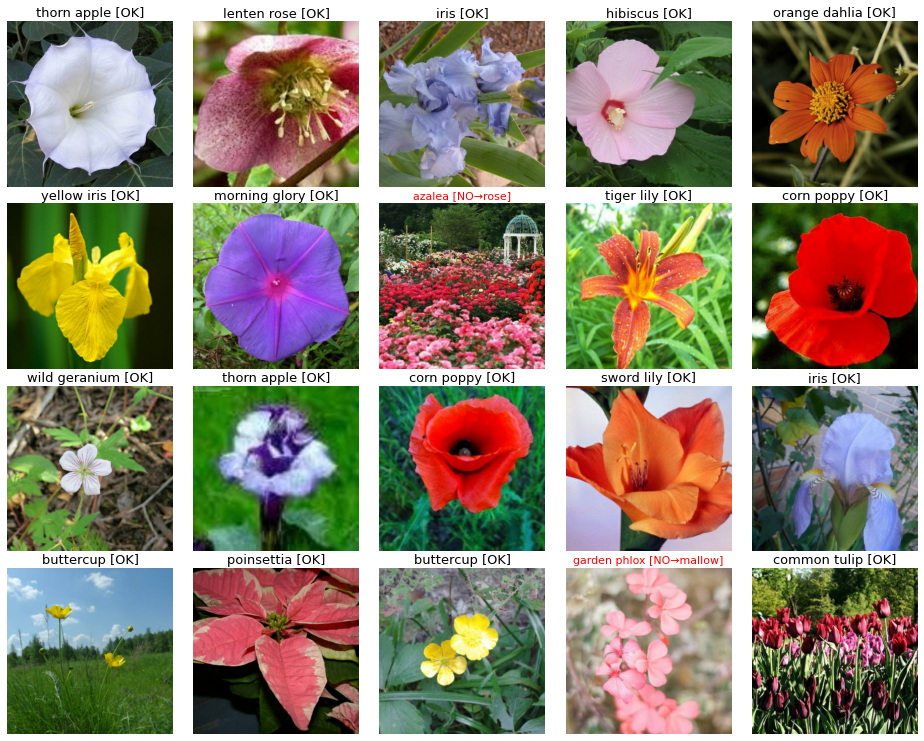

In [45]:
probabilities = np.zeros((all_probabilities[0].shape)) # = all_probabilities[0] + all_probabilities[1] + all_probabilities[2]
for j in range(no_of_models):
    probabilities = probabilities + all_probabilities[j]

predictions = np.argmax(probabilities, axis =-1)
display_batch_of_images((images, labels), predictions)

## Storing the Output for Ensembling
The initial reason for storing outputs of these models were to save time during ensembling. Loading the model saved and re-predicting for the validation and test set would take unusally longer compared to the time it took in the original kernel. Many a times giving the feeling that the kernel ensembling had hanged.

In [46]:
#val_probs = [cm_correct_labels, cm_predictions, test_ids, val_probabilities[0], val_probabilities[1], val_probabilities[2], test_probabilities[0], test_probabilities[1], test_probabilities[2]]
#val_probs = [cm_correct_labels, cm_predictions, test_ids, val_probabilities[0], val_probabilities[1], test_probabilities[0], test_probabilities[1]]
val_probs = [cm_correct_labels, cm_predictions, test_ids, val_probabilities[0], test_probabilities[model_indx_0]]
filename = this_run_file_prefix + 'tests_vals_0.pkl'
pklfile = open(filename, 'ab')
pickle.dump(val_probs, pklfile)
pklfile.close()

Here the intention was to display the validation images that were incorrectly predicted. But some how the commented code which had worked on the local PC did not work through the kernel. And so abandoned the idea of displaying them.

In [47]:
#images_ds_unbatched = images_ds.unbatch()
#cm_images_ds_numpy = next(iter(images_ds_unbatched.batch(NUM_VALIDATION_IMAGES))).numpy()
use_correct_labels = cm_correct_labels
use_val_predictions = best_predictions

In [48]:
print('type of labels_ds is {}'.format(type(labels_ds)))
print('type of use_val_predictions is {}. shape of use_val_predictions is {}'.format(type(use_val_predictions), use_val_predictions.shape))
#print('type of use_correct_labels is {}, cm_images_ds_numpy is {}'.format(type(use_correct_labels), type(cm_images_ds_numpy)))
#print('shape of use_correct_labels is {}, cm_images_ds_numpy is {}'.format(use_correct_labels.shape, cm_images_ds_numpy.shape))

type of labels_ds is <class 'tensorflow.python.data.ops.dataset_ops._UnbatchDataset'>
type of use_val_predictions is <class 'numpy.ndarray'>. shape of use_val_predictions is (3712,)


In [49]:
correct_labels_cnt = 0
incorrect_labels_cnt = 0
correct_labels = []
incorrect_labels = []
vals_actual_true = {}
vals_tp = {}
vals_fn = {}
vals_fp = {}
for i in range(len(CLASSES)):
    vals_actual_true[i] = 0
    vals_tp[i] = 0
    vals_fn[i] = 0
    vals_fp[i] = 0

for i in range(len(use_correct_labels)):
    correct_label = use_correct_labels[i]
    predict_label = use_val_predictions[i]
    vals_actual_true[correct_label] = vals_actual_true[correct_label] + 1
    if use_val_predictions[i] != use_correct_labels[i]:
        incorrect_labels_cnt = incorrect_labels_cnt + 1
        incorrect_labels.append(i)
        vals_fn[correct_label] = vals_fn[correct_label] + 1
        vals_fp[predict_label] = vals_fp[predict_label] + 1
    else:
        correct_labels_cnt = correct_labels_cnt + 1
        correct_labels.append(i)
        vals_tp[correct_label] = vals_tp[correct_label] + 1
#        print(i)
#
print('Number of correct_labels is {}, incorrect_labels is {}'.format(correct_labels_cnt, incorrect_labels_cnt))
#print('Correct labels', correct_labels)
print('Incorrect labels', incorrect_labels)
#

Number of correct_labels is 3524, incorrect_labels is 188
Incorrect labels [12, 19, 54, 88, 100, 104, 126, 149, 150, 190, 195, 215, 231, 277, 296, 314, 323, 374, 401, 426, 427, 442, 492, 509, 533, 573, 601, 607, 611, 627, 636, 644, 651, 657, 664, 676, 678, 692, 696, 720, 742, 756, 778, 786, 869, 893, 896, 920, 945, 955, 973, 974, 988, 1005, 1006, 1021, 1047, 1069, 1106, 1119, 1127, 1147, 1152, 1187, 1205, 1223, 1230, 1246, 1258, 1269, 1273, 1277, 1279, 1288, 1302, 1318, 1373, 1398, 1419, 1469, 1485, 1495, 1525, 1548, 1551, 1561, 1623, 1656, 1659, 1686, 1714, 1720, 1727, 1739, 1743, 1843, 1844, 1854, 1940, 1997, 2041, 2077, 2096, 2100, 2109, 2136, 2137, 2143, 2169, 2170, 2177, 2212, 2219, 2231, 2282, 2334, 2344, 2370, 2376, 2388, 2390, 2394, 2421, 2441, 2455, 2465, 2469, 2479, 2485, 2500, 2524, 2538, 2552, 2562, 2590, 2631, 2633, 2667, 2678, 2681, 2686, 2716, 2724, 2729, 2737, 2747, 2811, 2843, 2860, 2864, 2886, 2938, 2946, 2948, 2971, 3005, 3014, 3020, 3059, 3071, 3109, 3118, 3128, 312

In [50]:
def display_my_batch_of_images(databatch, rows = 0, cols = 0, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = databatch
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    if rows == 0 or cols == 0:
        rows = int(math.sqrt(len(images)))
        cols = (len(images) + rows - 1)//rows
    print('Total number of images is {}, rows is {}, cols is {}'.format(len(images), rows, cols))

    # size and spacing
    FIGSIZE = 20.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
#

In [51]:
#disp_images = []
disp_labels = []
disp_predictions = []
for i in range(54):
    if i >= incorrect_labels_cnt:
        break
    id = incorrect_labels[i]
    disp_labels.append(use_correct_labels[id])
    disp_predictions.append(use_val_predictions[id])
#    disp_images.append(cm_images_ds_numpy[id])
#
print(disp_labels)
print(disp_predictions)
#

[82, 48, 73, 51, 52, 81, 45, 45, 96, 103, 0, 95, 15, 67, 84, 69, 96, 95, 79, 96, 5, 102, 67, 48, 46, 95, 43, 10, 68, 103, 48, 73, 3, 82, 70, 16, 7, 49, 48, 3, 87, 42, 73, 82, 102, 39, 21, 48, 90, 50, 14, 50, 47, 87]
[85, 68, 71, 4, 41, 103, 28, 50, 31, 73, 73, 73, 47, 68, 97, 68, 4, 73, 19, 4, 17, 66, 14, 70, 53, 73, 45, 102, 47, 73, 68, 102, 89, 85, 5, 62, 89, 46, 33, 0, 94, 5, 48, 85, 30, 17, 95, 47, 5, 75, 67, 97, 103, 3]


In [52]:
#print('type of disp_images is {}, disp_labels is {}'.format(type(disp_images), type(disp_labels)))
#print('length of disp_images is {}, disp_labels is {}'.format(len(disp_images), len(disp_labels)))
#print('type of disp_images[0] is {}, disp_labels[0] is {}'.format(type(disp_images[0]), type(disp_labels[0])))

In [53]:
#display_my_batch_of_images((disp_images, disp_labels), rows = 9, cols = 6, predictions = disp_predictions)

The goal here was to gather information on which class of flowers had failed badly and to be able to use data augmentation for only those class of flowers. Finally never got to pursue it.

In [54]:
val_ids = list(range(len(use_correct_labels)))
filename = this_run_file_prefix + 'validation_results.csv'
np.savetxt(filename, np.rec.fromarrays([val_ids, use_correct_labels, use_val_predictions]), fmt = ['%d', '%d', '%d'], delimiter = ',', header = 'id,correct_label,predicted_label', comments = '')
#
cls_ids = list(range(len(CLASSES)))
#print(len(cls_ids), len(vals_actual_true), len(vals_tp), len(vals_fn), len(vals_fp))
filename = this_run_file_prefix + 'validation_statistics.csv'
np.savetxt(filename, np.rec.fromarrays([cls_ids, list(vals_actual_true.values()), list(vals_tp.values()), list(vals_fn.values()), list(vals_fp.values())]), fmt = ['%d', '%d', '%d', '%d', '%d'], delimiter = ',', header = 'cls_id,actual_true,true_positive,false_negative,false_positive', comments = '')
#